# Imports

In [1]:
import time
import json
import matplotlib.pyplot as plt
import torch

import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import os
from torchvision.io import read_image
from PIL import Image

import numpy as np
import matplotlib.patches as patches
from torchvision import transforms

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torchmetrics.detection.map import MeanAveragePrecision

import pycocotools

In [2]:
# imports from local lib files
import utils
import transforms
import coco_eval
from engine import train_one_epoch, evaluate

In [3]:
# Imports for evaluation from local lib files
from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
from engine import _get_iou_types 

# Baseline

## File paths

In [4]:
output_path = 'output'
img_folder = 'eccv_18_all_images_sm'

cis_test_ann_path = 'eccv_18_annotation_files/cis_test_annotations.json'
cis_val_ann_path = 'eccv_18_annotation_files/cis_val_annotations.json'
train_ann_path = 'eccv_18_annotation_files/train_annotations.json'
trans_test_ann_path = 'eccv_18_annotation_files/trans_test_annotations.json'
trans_val_ann_path = 'eccv_18_annotation_files/trans_val_annotations.json'

## Basic data exploration

In [5]:
cis_test_ann = json.load(open(cis_test_ann_path))
cis_val_ann = json.load(open(cis_val_ann_path))
train_ann = json.load(open(train_ann_path))
trans_test_ann = json.load(open(trans_test_ann_path))
trans_val_ann = json.load(open(trans_val_ann_path))

In [6]:
print('cis test set length:', len(cis_test_ann['images']))
print('cis val set length:', len(cis_val_ann['images']))
print('train set length:', len(train_ann['images']))
print('trans test set length:', len(trans_test_ann['images']))
print('trans val set length:', len(trans_val_ann['images']))

cis test set length: 15827
cis val set length: 3484
train set length: 13553
trans test set length: 23275
trans val set length: 1725


In [7]:
# i = 0

# boxes = [trans_val_ann['annotations'][j]['bbox'] for j in range(len(trans_val_ann['annotations'])) 
#          if trans_val_ann['annotations'][j]['image_id']==trans_val_ann['images'][i]['id'] 
#          and 'bbox' in trans_val_ann['annotations'][j].keys()]

# img_path = os.path.join('eccv_18_all_images_sm', trans_val_ann['images'][i]['file_name']) # to change

# image = read_image(img_path)

# fig, ax = plt.subplots()
# ax.imshow(image[0].squeeze(),cmap="gray")

# scale_x = image.shape[2] / trans_val_ann['images'][i]['width'] 
# scale_y = image.shape[1] / trans_val_ann['images'][i]['height']

# boxes = torch.as_tensor(boxes)

# for i in range(boxes.shape[0]):
#     boxes[i][0] = torch.round(boxes[i][0] * scale_x)
#     boxes[i][1] = torch.round(boxes[i][1] * scale_y)
#     boxes[i][2] = torch.round(boxes[i][2] * scale_x)
#     boxes[i][3] = torch.round(boxes[i][3] * scale_y)

#     boxes[i][2] = boxes[i][0] + boxes[i][2]
#     boxes[i][3] = boxes[i][1] + boxes[i][3]

# target = {}
# target["boxes"] = boxes

# rect = patches.Rectangle((boxes[0][0], boxes[0][1]), boxes[0][2]-boxes[0][0], 
#                          boxes[0][3]-boxes[0][1], linewidth=2, edgecolor='r', facecolor='none')
# ax.add_patch(rect)

## Utils

In [8]:
# In paper :  ' ... and employ horizontal flipping for data augmentation. ( for detection)

import transforms as T   # from git hub repo

data_transform = {'train': T.RandomHorizontalFlip(0.5)}

In [9]:
# Returns a list with the idx of images with at least one bounding box (img_wbbox) and a 
# list with the number of bbox for each valid image (num_bbox)
def get_img_with_bbox(file_path):
  
    file = json.load(open(file_path))
    img_wbbox = []
    num_bbox = []

    for i in range(len(file['images'])):
        bboxes = [file['annotations'][j]['bbox'] 
                  for j in range(len(file['annotations'])) 
                  if file['annotations'][j]['image_id']==file['images'][i]['id'] 
                  and 'bbox' in file['annotations'][j].keys()]

        if len(bboxes)!=0:
            img_wbbox.append(i)

            num_bbox.append(len(bboxes))

    return img_wbbox, num_bbox

In [10]:
class CustomImageDataset(Dataset):
    def __init__(self, label_path, img_dir, valid_img, transform = None):
        self.label_file = json.load(open(label_path))
        self.img_dir = img_dir
        self.transform = transform
        self.valid_img = valid_img

    def __len__(self):
        return len(self.valid_img)

    def __getitem__(self, idx):
        
        idx = self.valid_img[idx] # consider only images with bbox annotations
        img_path = os.path.join(self.img_dir, self.label_file['images'][idx]['file_name'])
        image = read_image(img_path)

        conv = torchvision.transforms.ToTensor()
        # if image.shape[0]==1:
        # some images have only one channel, we convert them to rgb
        image = Image.open(img_path).convert("RGB")
        image = conv(image)

        boxes = [self.label_file['annotations'][j]['bbox'] 
                 for j in range(len(self.label_file['annotations'])) 
                 if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]
        
        label = [self.label_file['annotations'][j]['category_id'] 
                 for j in range(len(self.label_file['annotations'])) 
                 if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]

        # transform bbox coords to adjust for resizing
        scale_x = image.shape[2] / self.label_file['images'][idx]['width'] 
        scale_y = image.shape[1] / self.label_file['images'][idx]['height']

        boxes = torch.as_tensor(boxes)
        for i in range(boxes.shape[0]):
            boxes[i][0] = torch.round(boxes[i][0] * scale_x)
            boxes[i][1] = torch.round(boxes[i][1] * scale_y)
            boxes[i][2] = torch.round(boxes[i][2] * scale_x)
            boxes[i][3] = torch.round(boxes[i][3] * scale_y)

            boxes[i][2] = boxes[i][0] + boxes[i][2] # to transform to pytorch bbox format
            boxes[i][3] = boxes[i][1] + boxes[i][3]

        label = torch.as_tensor(label)
        label = torch.where(label==30,0,1)  # 0 if empty (categ id = 30), 1 if animal
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = label
        target["image_id"] = image_id
        target['area']=area
        target['iscrowd']=iscrowd

        # TO DO : resize all to same size

        if self.transform:
            # transform image AND target
            image, target = self.transform(image, target)

        return image, target

## Pre-trained models
Inspred from https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/torchvision_finetuning_instance_segmentation.ipynb#scrollTo=YjNHjVMOyYlH

### Model with only the last layer to train

In [ ]:
def get_model_from_pretrained(num_classes):

    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    for param in model.parameters(): # to freeze all existing weights
        param.requires_grad = False

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

### Model with deeper layers to train

In [ ]:
def get_model_from_pretrained(num_classes):

    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    for param in model.parameters(): # to freeze all existing weights
        param.requires_grad = False

    for param in model.roi_heads.parameters():
        param.requires_grad = True

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

### Model with even deeper layers to train

In [11]:
def get_model_from_pretrained(num_classes):

    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    for param in model.parameters(): # to freeze all existing weights

        param.requires_grad = False

    for param in model.roi_heads.parameters():

        param.requires_grad = True

    for param in model.rpn.parameters():

        param.requires_grad = True

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

### Params

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_model_from_pretrained(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0003, momentum=0.9)

# like in the paper, construct the scheduler
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[5,10], gamma=0.1)

## OPTIONAL - Loading/Importing a model
#### Need to initiate the model, the optimizer and de scheduler before loading

In [13]:
# NEED TO INITIATE THE MODEL, THE OPTIMIZER AND THE SCHEDULER BEFOREHAND (if )
# load the model, the optimizer and the scheduler
model.load_state_dict(torch.load('saved_models/50_rpn_roi_1_model.pt'))
optimizer.load_state_dict(torch.load('saved_models/50_rpn_roi_1_optimizer.pt'))
lr_scheduler.load_state_dict(torch.load('saved_models/50_rpn_roi_1_scheduler.pt'))

## Create the dataloaders
To load the data of the dataset efficiently for the model

In [14]:
def create_dataloader(ann_path, batch_size, shuffle=True, transform=None):
    images_with_bbox,_ = get_img_with_bbox(ann_path)
    data = CustomImageDataset(ann_path, img_folder, images_with_bbox, transform)
    return DataLoader(data, batch_size=batch_size, shuffle=shuffle, collate_fn=utils.collate_fn)

#### You can specify the data augmentation transformation at will

In [15]:
train_dataloader = create_dataloader(train_ann_path, 1)
cis_valid_dataloader = create_dataloader(cis_val_ann_path, 10)
trans_valid_dataloader = create_dataloader(trans_val_ann_path, 10)
cis_test_dataloader = create_dataloader(cis_test_ann_path, 10)
trans_test_dataloader = create_dataloader(trans_test_ann_path, 10)

## Logs utils

#### Train logs utils

In [16]:
import time

In [17]:
# Converts the smoothed values to a dictionnary of each values
def smoothed_value_to_str(smoothed_value):
    d_values = {}
    d_values['median'] = smoothed_value.median
    d_values['avg'] = smoothed_value.avg
    d_values['global_avg'] = smoothed_value.global_avg
    d_values['max'] = smoothed_value.max
    d_values['value'] = smoothed_value.value
    return d_values


# Converts the train logs from MetricLogger to list
def train_logs_to_lst(logs):
    lst = []
    for i in range(len(logs)):
        d = {}
        for key in logs[i].meters.keys():
            d[key] = smoothed_value_to_str(logs[i].meters[key])
        lst.append(d)
    return lst


# Puts the training logs into a json file with time dependent file name
def train_logs_to_json(logs, ftime=time.strftime("%Y%m%d_%H%M%S")):
    train_metric_logs = train_logs_to_lst(logs)
    filename = ftime + "_train_logs.json"
    
    with open('saved_logs/' + filename, 'w', encoding='utf-8') as f:
        json.dump(train_metric_logs, f, ensure_ascii=False, indent=4)

In [18]:
# Converts the train logs from MetricLogger to list
def train_logs_to_lst(logs):
    lst = []
    for i in range(len(logs)):
        d = {}
        for key in logs[i].meters.keys():
            d[key] = smoothed_value_to_str(logs[i].meters[key])
        lst.append(d)
    return lst

In [19]:
# Puts the training logs into a json file with time dependent file name
def train_logs_to_json(logs, ftime=time.strftime("%Y%m%d_%H%M%S")):
    train_metric_logs = train_logs_to_lst(logs)
    filename = ftime + "_train_logs.json"
    
    with open('saved_logs/' + filename, 'w', encoding='utf-8') as f:
        json.dump(train_metric_logs, f, ensure_ascii=False, indent=4)

#### Valid logs utils

In [20]:
# Merge the dicts of a list 
def merge_dict(logs):
    logs_better = []
    try:
        for i in range(len(logs)):
            logs_better.append({**logs[i][0], **logs[i][1], **logs[i][2], **logs[i][3]})
        return logs_better
    except:
        print(logs[0])
        logs_better = logs
        return logs_better

In [21]:
# Converts the valid logs from list of dictionnaries to string
# TODO: add if type == list to not do anything if its already a list
def valid_logs_to_lst(valid_logs):
    logs = merge_dict(valid_logs)
    lst = []
    for i in range(len(logs)):
        d = {}
        for key in logs[i].keys():
            d[key] = logs[i][key].cpu().numpy().tolist()
        lst.append(d)
    return lst

In [22]:
# Puts the cis validation logs into a json file with time dependent file name
def cis_valid_logs_to_json(logs, ftime=time.strftime("%Y%m%d_%H%M%S")):
    valid_metric_logs = valid_logs_to_lst(logs)
    filename = ftime + "_cis_valid_logs.json"
    
    with open('saved_logs/' + filename, 'w', encoding='utf-8') as f:
        json.dump(valid_metric_logs, f, ensure_ascii=False, indent=4)

In [23]:
# Puts the trans validation logs into a json file with time dependent file name
def trans_valid_logs_to_json(logs, ftime=time.strftime("%Y%m%d_%H%M%S")):
    valid_metric_logs = valid_logs_to_lst(logs)
    filename = ftime + "_trans_valid_logs.json"
    
    with open('saved_logs/' + filename, 'w', encoding='utf-8') as f:
        json.dump(valid_metric_logs, f, ensure_ascii=False, indent=4)

# Training the model

In [24]:
# Defining the train function
def train(dataloader, num_epochs, save_logs=True, save_model=True, print_freq=100):
    
    model.train()
    
    all_train_logs = []
    all_cis_valid_logs = []
    all_trans_valid_logs = []

    for epoch in range(num_epochs):
        
        # train for one epoch, printing every 100 images
        train_logs = train_one_epoch(model, optimizer, dataloader, device, epoch, print_freq)
        all_train_logs.append(train_logs)
        
        # update the learning rate
        lr_scheduler.step()
        
        # evaluate on the validation dataset after training one epoch
        for images, targets in trans_valid_dataloader: # can do batch of 10 prob.
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            with torch.no_grad():
                trans_loss_dict = model(images, targets)
                trans_loss_dict = [{k: loss.to('cpu')} for k, loss in trans_loss_dict.items()]
                all_trans_valid_logs.append(trans_loss_dict)


        for images, targets in cis_valid_dataloader: # can do batch of 10 prob.
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            with torch.no_grad():
                cis_loss_dict = model(images, targets)
                cis_loss_dict = [{k: loss.to('cpu')} for k, loss in cis_loss_dict.items()]
                all_cis_valid_logs.append(cis_loss_dict)
    
    filetime = time.strftime("%Y%m%d_%H%M%S")
    
    if save_logs:
        
        # save the train, cis valid and trans valid logs
        train_logs_to_json(all_train_logs, filetime)
        cis_valid_logs_to_json(all_cis_valid_logs, filetime)
        trans_valid_logs_to_json(all_trans_valid_logs, filetime)
        
    if save_model:
        
        # save the model, the optimizer and the scheduler
        torch.save(model.state_dict(), 'saved_models/' + filetime + '_model.pt')
        torch.save(optimizer.state_dict(), 'saved_models/' + filetime + '_optimizer.pt')
        torch.save(lr_scheduler.state_dict(), 'saved_models/' + filetime + '_scheduler.pt')
    
    
    
    return all_train_logs, all_trans_valid_logs, all_cis_valid_logs


### Before training

In [ ]:
# PARAMETERS TO TUNE BEFORE TRAINING
num_epochs = 25

# CHECK DEVICE BEFORE TRAINING
torch.cuda.get_device_name(0)

### This next cell starts the training of the model

In [ ]:
# TRAIN
all_train_logs, all_trans_valid_logs, all_cis_valid_logs = train(dataloader=train_dataloader, num_epochs=num_epochs)

### Saving the last training logs to variables

In [ ]:
last_train_logs = all_train_logs
last_trans_valid_logs = all_trans_valid_logs
last_cis_valid_logs = all_cis_valid_logs

## OPTIONAL - Saving manually every logs from training to json files

In [ ]:
# Saves the log with the same time
train_logs_to_json(last_train_logs)
trans_valid_logs_to_json(last_trans_valid_logs)
cis_valid_logs_to_json(last_cis_valid_logs)

## OPTIONAL - Saving the model

In [ ]:
# save the model, the optimizer and the scheduler
# filetime = "25_epochs_roi_3_augment_method_3"
filetime = time.strftime("%Y%m%d_%H%M%S")

torch.save(model.state_dict(), 'saved_models/' + filetime + '_model.pt')
torch.save(optimizer.state_dict(), 'saved_models/' + filetime + '_optimizer.pt')
torch.save(lr_scheduler.state_dict(), 'saved_models/' + filetime + '_scheduler.pt')

## Exploration of the raw logs
##### Only look at the MetricLogger if you just trained the model. You cannot import the model and then check the MetricLogger.

In [ ]:
all_train_logs[0].meters

In [ ]:
all_train_logs[0].meters['loss_box_reg'].global_avg

In [ ]:
len(train_dataloader)

#### Here we check the amount of logs per epoch for each categories and the type

In [ ]:
print(all_cis_valid_logs[0])
print("total length:", len(all_cis_valid_logs))
print("-"*8)
print("per epoch length:", len(all_cis_valid_logs)/num_epochs)

In [ ]:
print(all_trans_valid_logs[0])
print("total length:", len(all_trans_valid_logs))
print("-"*8)
print("per epoch length:", len(all_trans_valid_logs)/num_epochs)

## Looking at/Loading the logs in convenient ways
Here we define the variables "train_logs", "cis_valid_logs" and "trans_valid_logs" that will be used in the methods for the results and the visualisations.

We can import logs or use the ones from training.

### OPTIONAL - Can load some logs right here

In [ ]:
# Imported logs - format: name = "NAME_OR_TIME"      Exemple file format: "NAME_OR_TIME_train_logs"

file_time_or_nickname = '10_roi' # VALUE TO CHANGE TO THE IMPORTED FILES

# Import training logs
with open('saved_logs/' + file_time_or_nickname + '_train_logs.json', "r") as f:
    train_logs = json.load(f)

# Import cis valid logs
with open('saved_logs/' + file_time_or_nickname + '_cis_valid_logs.json', "r") as f:
    cis_valid_logs = json.load(f)

# Import trans valid logs
with open('saved_logs/' + file_time_or_nickname + '_trans_valid_logs.json', "r") as f:
    trans_valid_logs = json.load(f)

### Put the last trained logs into convenient list variables
#### (USE THIS CELL ONLY IF MODEL HAVE BEEN TRAINED IN THIS KERNEL)

##### Ensures that if you hit the training cell, you don't lose the variables containing the logs from the last run

In [ ]:
last_train_logs = all_train_logs
last_trans_valid_logs = all_trans_valid_logs
last_cis_valid_logs = all_cis_valid_logs

##### Converts the logs to lists and the tensors to numpy 

In [ ]:
train_logs = train_logs_to_lst(last_train_logs)
cis_valid_logs = valid_logs_to_lst(last_cis_valid_logs)
trans_valid_logs = valid_logs_to_lst(last_trans_valid_logs)

## Results

In [ ]:
# To confirm that the data is loaded properly
len(train_logs)

In [ ]:
num_epochs = len(train_logs)

In [ ]:
# Train loss to print (here we use global_avg but we can use: value, median, avg, max or global_avg)
results_train_loss = []

for i in range(num_epochs):
    results_train_loss.append(train_logs[i]['loss_box_reg']['global_avg'])
    
# Cis valid loss to print
results_cis_valid_loss = [] # cis

for i in range(num_epochs):
    loss_interm = 0
    for j in range(167):
        loss_interm += cis_valid_logs[(167 * i) + j]['loss_box_reg']
    results_cis_valid_loss.append(loss_interm)

# Trans valid loss to print
results_trans_valid_loss = [] # cis

for i in range(num_epochs):
    loss_interm = 0
    for j in range(154):
        loss_interm += trans_valid_logs[(154 * i) + j]['loss_box_reg']
    results_trans_valid_loss.append(loss_interm)

### Plots

In [ ]:
# Printing the different plots
fig, ax = plt.subplots(1,2, figsize=(20,6))

ax[0].plot(np.arange(1, num_epochs + 1), results_train_loss, label='train')
ax[0].set_title('Train loss per epoch')
ax[0].set_ylabel('loss_box_reg')
ax[0].set_xlabel('epoch')

plt.title('Train loss per epoch')
ax[1].plot(np.arange(1, num_epochs + 1), results_cis_valid_loss, label='cis')
ax[1].plot(np.arange(1, num_epochs + 1), results_trans_valid_loss, label='trans')
ax[1].set_title('Valid loss per epoch')
ax[1].set_ylabel('loss_box_reg')
ax[1].set_xlabel('epoch')
ax[1].legend()

#### Save the figure to pdf format in the figures folder

In [ ]:
fig.savefig("figures/" + time.strftime("%Y%m%d_%H%M%S") + "_figure.pdf")

## Make Predictions with a model

### Load 10 random predictions

In [45]:
# Loads 10 images and makes the model do predictions on these images
train_features, train_labels = next(iter(trans_valid_dataloader))
image = list(image.to(device) for image in train_features)

model.eval()
with torch.no_grad():
      pred = model(image)

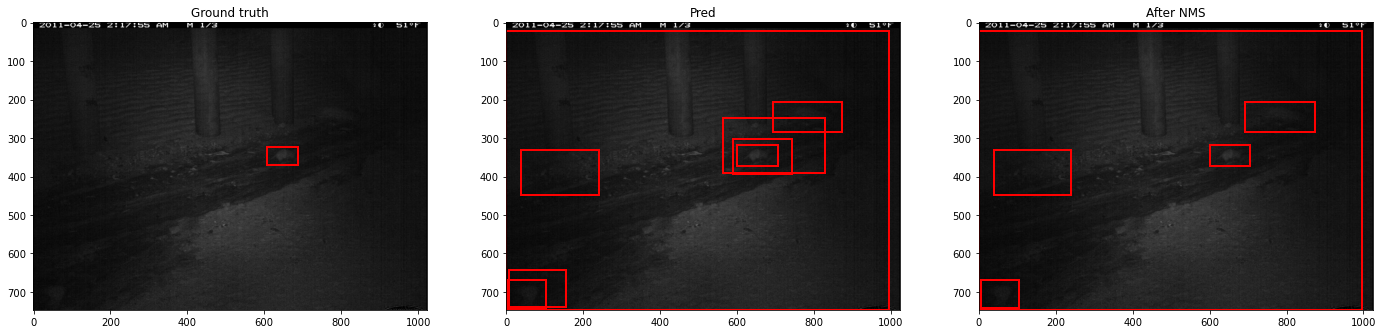

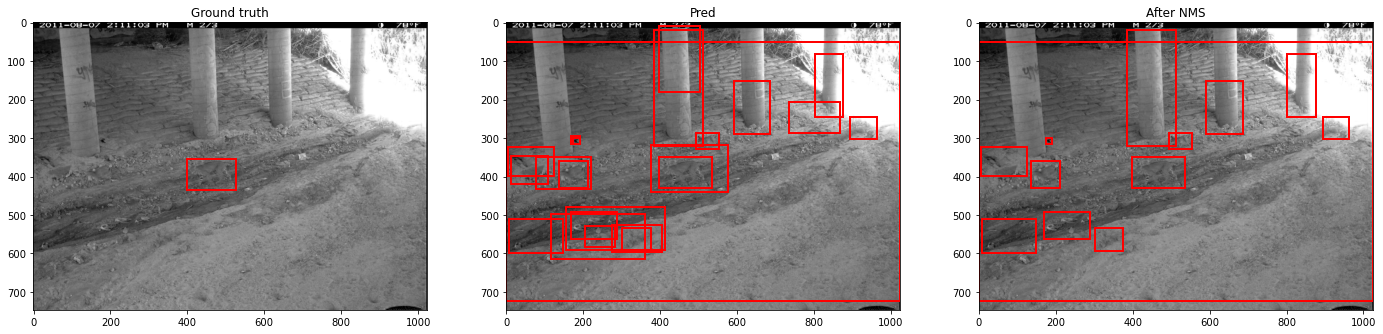

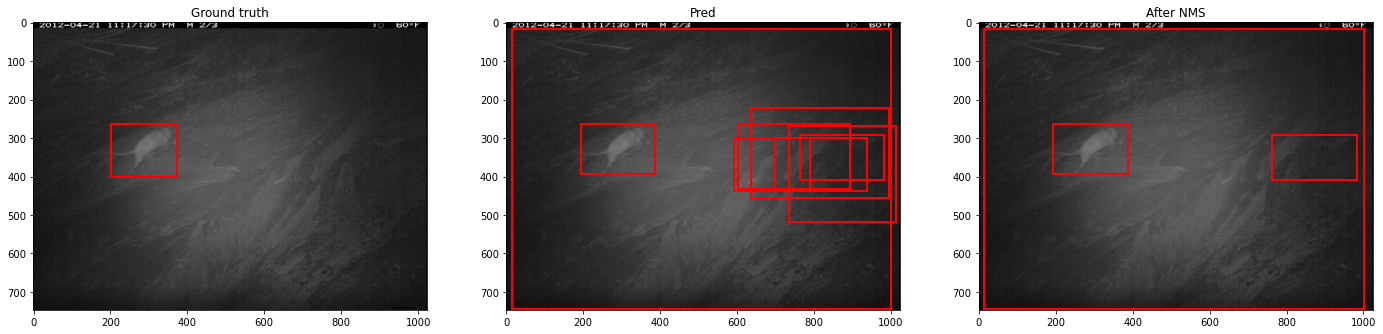

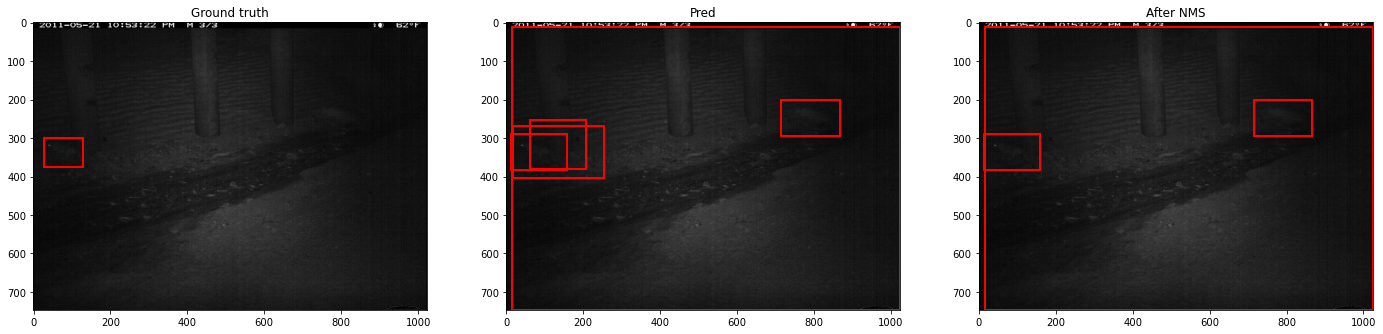

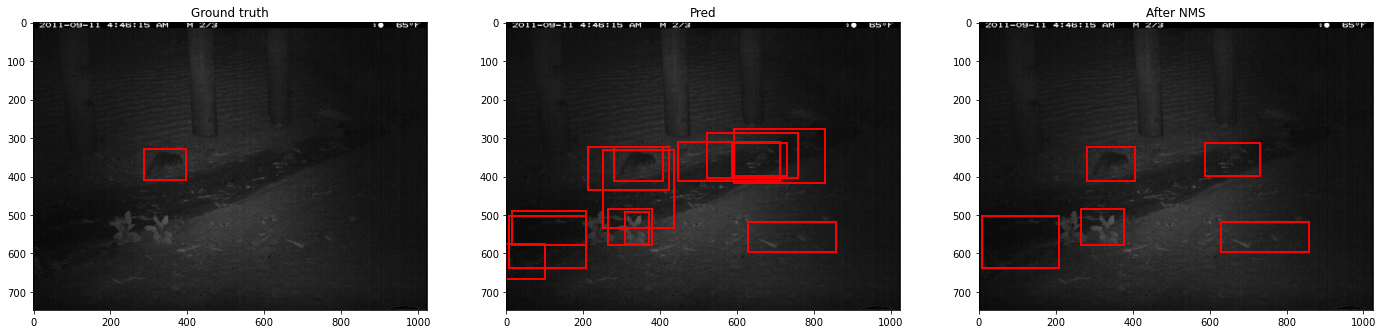

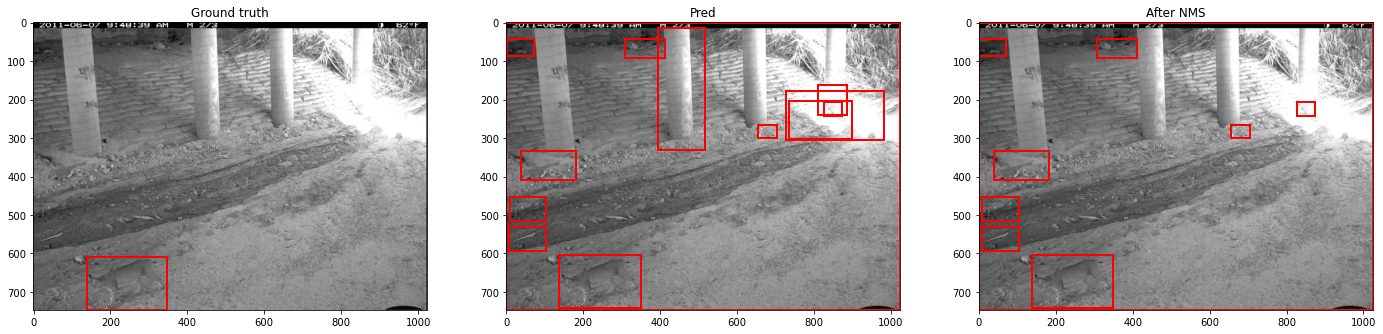

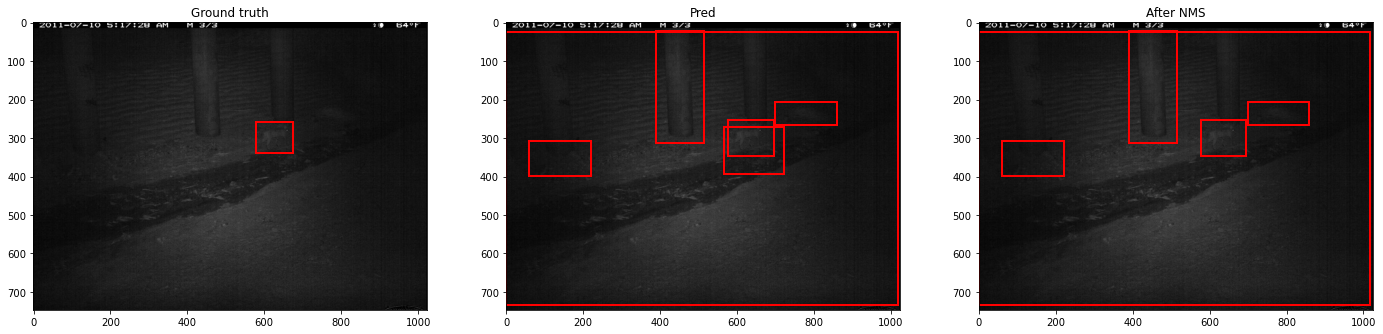

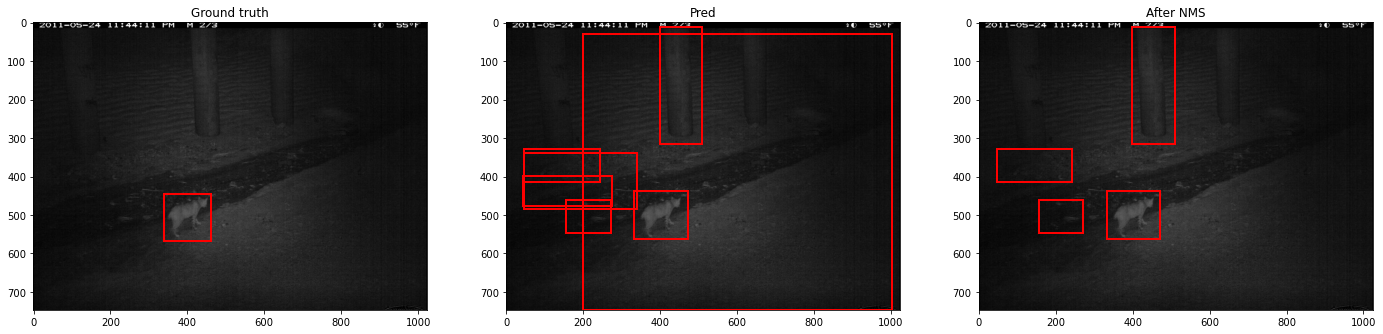

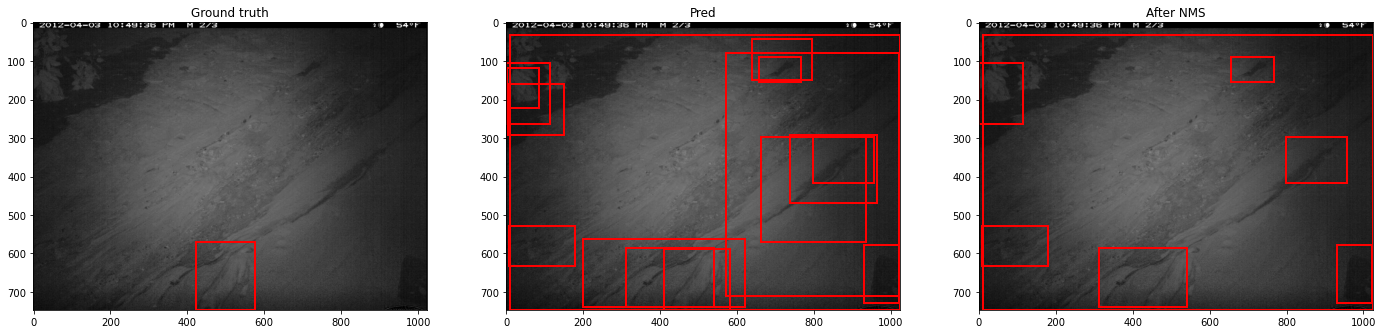

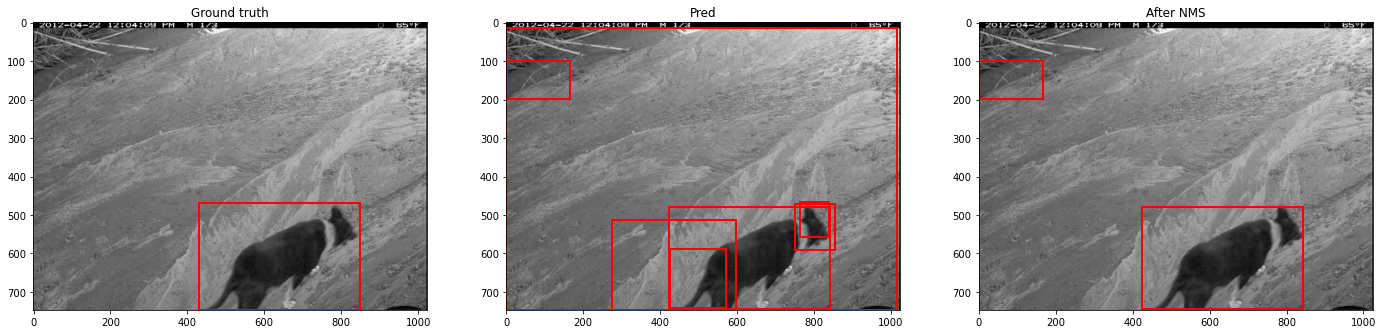

In [48]:
# Prints 10 images with the predictions before and after NMS
# TODO: faire des méthodes pour simplifier le code
for image_i in range(len(image)):
    fig, ax = plt.subplots(1,3,figsize=(24,16))

    ax[0].imshow(train_features[image_i][0].squeeze(),cmap="gray")
    rect = patches.Rectangle((train_labels[image_i]['boxes'][0][0], 
                              train_labels[image_i]['boxes'][0][1]), 
                             train_labels[image_i]['boxes'][0][2]-train_labels[image_i]['boxes'][0][0], 
                             train_labels[image_i]['boxes'][0][3]-train_labels[image_i]['boxes'][0][1], 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)
    ax[0].set_title('Ground truth')

    # Predictions
    ax[1].imshow(train_features[image_i][0].squeeze(),cmap="gray")
    for i in range(len(pred[image_i]['boxes'])):
        rect = patches.Rectangle((pred[image_i]['boxes'][i][0].cpu(), 
                                  pred[image_i]['boxes'][i][1].cpu()), 
                                 (pred[image_i]['boxes'][i][2]-pred[image_i]['boxes'][i][0]).cpu(), 
                                 (pred[image_i]['boxes'][i][3]-pred[image_i]['boxes'][i][1]).cpu(), 
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax[1].add_patch(rect)
    ax[1].set_title('Pred')

    # Predictions after NMS
    iou_threshold = 0.05 # param to tune
    boxes_to_keep = torchvision.ops.nms(pred[image_i]['boxes'], pred[image_i]['scores'], iou_threshold = iou_threshold).cpu()
    ax[2].imshow(train_features[image_i][0].squeeze(),cmap="gray")
    for i in boxes_to_keep:
        rect = patches.Rectangle((pred[image_i]['boxes'][i][0].cpu(), 
                                  pred[image_i]['boxes'][i][1].cpu()), 
                                 (pred[image_i]['boxes'][i][2]-pred[image_i]['boxes'][i][0]).cpu(), 
                                 (pred[image_i]['boxes'][i][3]-pred[image_i]['boxes'][i][1]).cpu(), 
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax[2].add_patch(rect)

    ax[2].set_title('After NMS')

In [ ]:
trans_val_ann['images'][train_labels[3]['image_id']]

In [ ]:
# Print a single image chosen by index from the last batch of 10 predictions
image_i = 3 # from 0 to 9 included

fig, ax = plt.subplots(1,3,figsize=(24,16))

ax[0].imshow(train_features[image_i][0].squeeze(),cmap="gray")
for i in range(len(train_labels[image_i]['boxes'])):
    rect = patches.Rectangle((train_labels[image_i]['boxes'][i][0], 
                            train_labels[image_i]['boxes'][i][1]), 
                            train_labels[image_i]['boxes'][i][2]-train_labels[image_i]['boxes'][i][0], 
                            train_labels[image_i]['boxes'][i][3]-train_labels[image_i]['boxes'][i][1], 
                            linewidth=2, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)
ax[0].set_title('Ground truth')

# Predictions
ax[1].imshow(train_features[image_i][0].squeeze(),cmap="gray")
for i in range(len(pred[image_i]['boxes'])):
    rect = patches.Rectangle((pred[image_i]['boxes'][i][0].cpu(), 
                              pred[image_i]['boxes'][i][1].cpu()), 
                             (pred[image_i]['boxes'][i][2]-pred[image_i]['boxes'][i][0]).cpu(), 
                             (pred[image_i]['boxes'][i][3]-pred[image_i]['boxes'][i][1]).cpu(), 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax[1].add_patch(rect)
ax[1].set_title('Pred')

# Predictions after NMS
iou_threshold = 0.01 # param to tune
boxes_to_keep = torchvision.ops.nms(pred[image_i]['boxes'], pred[image_i]['scores'], iou_threshold = iou_threshold).cpu()
ax[2].imshow(train_features[image_i][0].squeeze(),cmap="gray")
for i in boxes_to_keep:
    rect = patches.Rectangle((pred[image_i]['boxes'][i][0].cpu(), 
                              pred[image_i]['boxes'][i][1].cpu()), 
                             (pred[image_i]['boxes'][i][2]-pred[image_i]['boxes'][i][0]).cpu(), 
                             (pred[image_i]['boxes'][i][3]-pred[image_i]['boxes'][i][1]).cpu(), 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax[2].add_patch(rect)

ax[2].set_title('After NMS')

In [ ]:
boxes_to_keep

In [ ]:
pred[image_i]['boxes'][0]

In [ ]:
train_labels[image_i]['boxes']

# Evalutate on COCO detection metrics

### Define the coco dataset from the data loaders

In [41]:
cis_coco = get_coco_api_from_dataset(cis_test_dataloader.dataset)
trans_coco = get_coco_api_from_dataset(trans_test_dataloader.dataset)

creating index...
index created!
creating index...
index created!


### Test on COCO metrics from data loaders
##### 'For evaluation, we consider a detected box to be correct if its IoU ≥ 0.5 with a ground truth box.'

We need to look at the precison score with IoU=0.5, area=all and maxDets=100.
For the recall score, by default it's IoU=0.5:IoU=0.95.

In [42]:
# TODO: méthode pour évaluer 
def evaluate(dataloader, coco, nms=True, iou=0.35):
    apply_nms = nms
    iou_threshold = iou # param to potentially tune (threshold for nms)
    the_data_loader = dataloader # change to test set
    
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    model.eval()

    for images, targets in the_data_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():

            pred=model(images)

            if apply_nms:
                boxes_to_keep = torchvision.ops.nms(pred[0]['boxes'], pred[0]['scores'], iou_threshold=iou_threshold).cpu()
                pred[0]['boxes'] = pred[0]['boxes'][boxes_to_keep]
                pred[0]['labels'] = pred[0]['labels'][boxes_to_keep]
                pred[0]['scores'] = pred[0]['scores'][boxes_to_keep]

            outputs = [{k: v.cpu() for k, v in t.items()} for t in pred]
            res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
            coco_evaluator.update(res)
    
    coco_evaluator.synchronize_between_processes()
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    return coco_evaluator


In [43]:
# takes +- 25min to run on cis_test
cis_coco_evaluator = evaluate(cis_test_dataloader, cis_coco)

KeyboardInterrupt: 

In [ ]:
# takes +- 25min to run on cis_test
trans_coco_evaluator = evaluate(trans_test_dataloader, trans_coco)

# Methods

## Method 3 (Subspace alignment based Domain adaptation)

In [44]:
import torchvision.ops.boxes as bops
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torch import nn

Papers 

 1. https://arxiv.org/pdf/1507.05578.pdf

 2.  https://openaccess.thecvf.com/content_iccv_2013/papers/Fernando_Unsupervised_Visual_Domain_2013_ICCV_paper.pdf

**Construct source matrix:** 

We keep output of model.roi_heads.box_head (vector of size 1024) as feature representations of bounding boxes extracted by the RPN (region proposal network). For us to stack a box representation to the source matrix, it has to have a IoU > thres_IoU with the ground truth of the given image. 

In [49]:
# 20 minutes
thres_IoU = 0.50
count = 0

X_source = torch.tensor([])
bbox_idx = torch.arange(1000)

model.eval()

for images, targets in train_dataloader: 
    images = [image.to(device) for image in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    count += 1

    if count%100 == 0:
        print(count)

    with torch.no_grad():
        outputs = []
        hook = model.rpn.register_forward_hook(
        lambda self, input, output: outputs.append(output))

        outputs1 = []
        hook1 = model.roi_heads.box_head.register_forward_hook(
        lambda self, input, output: outputs1.append(output))

        res = model(images)
        hook.remove()
        hook1.remove()

    coords = outputs[0][0][0].cpu() # [1000,4]
    feat = outputs1[0].cpu() # [1000, 1024]

    gt = targets[0]['boxes'].cpu()

    bbox_idx_to_keep = torch.tensor([])
    for i in range(gt.shape[0]):

        IoUs = bops.box_iou(gt[i].reshape(1,4), coords)
        IoUs = IoUs.reshape(1000)
        bbox_idx_to_keep = torch.cat((bbox_idx_to_keep, bbox_idx[IoUs >= thres_IoU]),dim=0)

    X_source = torch.cat((X_source,feat[torch.unique(bbox_idx_to_keep).long()]), dim=0)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000


In [50]:
X_source.shape

torch.Size([105033, 1024])

### Save 1

In [51]:
torch.save(X_source, 'saved_data/X_source_05_50_rpn_roi_1.pt')

In [52]:
# center data
scaler = StandardScaler()
X_source_scaled = scaler.fit_transform(X_source)

In [53]:
# Apply PCA, keep only an amount of first components which gives the Projected source matrix

pca = PCA(n_components=512)
pca.fit(X_source_scaled)

X_source_proj = pca.components_
X_source_proj = torch.from_numpy(X_source_proj)


In [54]:
X_source_proj.shape

torch.Size([512, 1024])

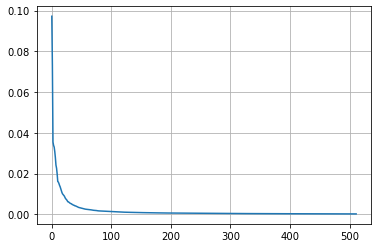

In [55]:
plt.plot(pca.explained_variance_ratio_) 
plt.grid()

### Save 2

In [56]:
torch.save(X_source_proj, 'saved_data/X_source_proj_05_50_rpn_roi_1.pt')

### Target data with batch size 1

In [57]:
# Target data/distribution = trans test set - Batch Size 1
trans_test_batch1_img,_ = get_img_with_bbox(trans_test_ann_path)
trans_test_batch1_data = CustomImageDataset(trans_test_ann_path, img_folder, trans_test_batch1_img)
trans_test_batch1_dataloader = DataLoader(trans_test_batch1_data, batch_size=1, shuffle=True, collate_fn=utils.collate_fn)

 **Construct target matrix:** 
 
We keep output of model.roi_heads.box_head (vector of size 1024) as feature representations of bounding boxes
 extracted by the RPN (region proposal network). For us to stack a box representation to the source matrix, the predicted bbox associated with the feature has to have a confidence score > thres_conf_score (since we don't use target labels we can't use the IoU here).


In [58]:
# 30 minutes
thres_conf_score= 0.50 
count=0

X_target=torch.tensor([])

model.eval()

for images, targets in trans_test_batch1_dataloader: # trans location valid AND test ?
    images = [image.to(device) for image in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    count+=1

    if count%100==0:
        print(count)

    with torch.no_grad():

        outputs = []
        hook = model.backbone.register_forward_hook(
        lambda self, input, output: outputs.append(output))
        res = model(images)
        hook.remove()

        box_features = model.roi_heads.box_roi_pool(outputs[0], [r['boxes'] for r in res], [i.shape[-2:] for i in images])
        box_features = model.roi_heads.box_head(box_features)

    X_target = torch.cat((X_target,box_features[res[0]['scores']>=thres_conf_score].cpu()), dim=0)


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000


In [59]:
X_target.shape

torch.Size([52096, 1024])

In [60]:
torch.save(X_target, 'saved_data/X_target_05_50_rpn_roi_1.pt')

In [61]:
# center data
scaler = StandardScaler()
X_target_scaled = scaler.fit_transform(X_target)

In [62]:
# Apply PCA, keep only an amount of first components which gives the Projected source matrix

pca_proj = PCA(n_components=512)
pca_proj.fit(X_target_scaled)

X_target_proj = pca_proj.components_
X_target_proj = torch.from_numpy(X_target_proj)

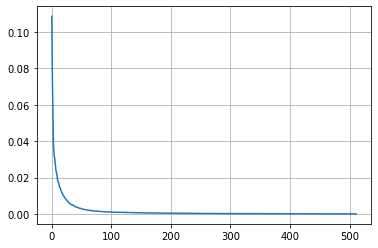

In [63]:
plt.plot(pca_proj.explained_variance_ratio_) # we keep 100 dimensions
plt.grid()

In [64]:
X_target_proj.shape

torch.Size([512, 1024])

In [65]:
torch.save(X_target_proj, 'saved_data/X_target_proj_05_50_rpn_roi_1.pt')

### Transformation matrix M

𝑀 is obtained by minimizing the following Bregman matrix divergence (following closed-form solution given in the paper)

In [ ]:
M = torch.matmul(X_source_proj, X_target_proj.T) 

In [ ]:
M.shape

### Project source data into target aligned source subspace

In [ ]:
Xa = torch.matmul(X_source_proj.T,M)

In [ ]:
Xa.shape

In [ ]:
# To project a given feature

# feat(1,1024) x Xa (1024,100)

### Projet target data in target subspace

In [ ]:
# To project a given feature

# feat(1,1024) x X_target_proj.T (1024,100)

### Train adapted model

In [ ]:
import torchvision.ops.boxes as bops
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torch import nn

In [ ]:
# CI CE N'EST PAS DÉJÀ FAIT

# Target data/distribution = trans test set - Batch Size 1
trans_test_batch1_img,_ = get_img_with_bbox(trans_test_ann_path)
trans_test_batch1_data = CustomImageDataset(trans_test_ann_path, img_folder, trans_test_batch1_img)
trans_test_batch1_dataloader = DataLoader(trans_test_batch1_data, batch_size=1, shuffle=True, collate_fn=utils.collate_fn)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

In [ ]:
# Load because it takes time to generate the following matrices so they are saved
X_source_proj = torch.load('saved_data/X_source_proj_05_50_rpn_roi_1.pt')
X_target_proj = torch.load('saved_data/X_target_proj_05_50_rpn_roi_1.pt')

In [ ]:
X_source_proj.device

In [66]:
M = torch.matmul(X_source_proj, X_target_proj.T) # transformation matrix
print(M.shape)

Xa = torch.matmul(X_source_proj.T,M) # target aligned source subspace
print(Xa.shape)

torch.Size([512, 512])
torch.Size([1024, 512])


In [67]:
M.to(device)

tensor([[-4.1935e-01,  7.2401e-01,  2.3667e-01,  ..., -8.8219e-03,
          1.8759e-03, -5.2955e-03],
        [ 7.2910e-01,  4.7153e-01,  2.1636e-02,  ...,  4.9789e-04,
          1.9853e-03, -6.0870e-03],
        [ 2.4538e-01, -1.6072e-01, -2.5955e-01,  ..., -6.6810e-03,
         -2.0625e-03, -7.7478e-03],
        ...,
        [ 5.8156e-03, -3.0229e-03, -3.7675e-03,  ..., -2.3556e-02,
         -5.6510e-03, -2.1359e-02],
        [-1.9727e-03, -7.1842e-03, -1.6053e-03,  ..., -9.8650e-02,
         -1.1761e-02,  3.6661e-02],
        [ 3.9567e-04, -1.4691e-03, -9.2095e-03,  ..., -1.9916e-02,
         -5.7050e-02,  1.0887e-01]], device='cuda:0', dtype=torch.float64)

In [68]:
Xa.to(device)

tensor([[-0.0107,  0.0486, -0.0223,  ..., -0.0727,  0.0033, -0.0263],
        [-0.0475,  0.0303,  0.0230,  ...,  0.0081, -0.0266, -0.0287],
        [-0.0102, -0.0375, -0.0632,  ...,  0.0088,  0.0116, -0.0047],
        ...,
        [ 0.0144,  0.0592, -0.0127,  ...,  0.0034,  0.0149,  0.0106],
        [-0.0693,  0.0159,  0.0014,  ...,  0.0119, -0.0016,  0.0021],
        [ 0.0300,  0.0718,  0.0033,  ..., -0.0149,  0.0241,  0.0041]],
       device='cuda:0', dtype=torch.float64)

In [ ]:
# class FastRCNNPredictor_custom(nn.Module):
#     """
#     Standard classification + bounding box regression layers
#     for Fast R-CNN.

#     Args:
#         in_channels (int): number of input channels
#         num_classes (int): number of output classes (including background)
#     """

#     def __init__(self, in_channels, num_classes, m_transfo):
#         super(FastRCNNPredictor_custom, self).__init__()
#         self.cls_score = nn.Sequential(nn.Linear(in_features = 1024, out_features = 100, bias=False), nn.Linear(in_channels, num_classes))
#         self.bbox_pred = nn.Sequential(nn.Linear(in_features = 1024, out_features = 100, bias=False), nn.Linear(in_channels, num_classes * 4))
#         self.cls_score[0].weight= nn.Parameter(m_transfo, requires_grad = False)
#         self.bbox_pred[0].weight= nn.Parameter(m_transfo, requires_grad = False)

#     def forward(self, x):
#         if x.dim() == 4:
#             assert list(x.shape[2:]) == [1, 1]
#         x = x.flatten(start_dim=1)
#         scores = self.cls_score(x)
#         bbox_deltas = self.bbox_pred(x)

#         return scores, bbox_deltas


In [69]:
class FastRCNNPredictor_custom(nn.Module):
    """
    Standard classification + bounding box regression layers
    for Fast R-CNN.

    Args:
        in_channels (int): number of input channels
        num_classes (int): number of output classes (including background)
    """

    def __init__(self, in_channels, num_classes, m_transfo):
        super(FastRCNNPredictor_custom, self).__init__()
        self.cls_score = nn.Sequential(nn.Linear(in_features=1024, out_features = in_channels, bias=False),nn.Linear(in_channels, num_classes))
        self.bbox_pred = nn.Sequential(nn.Linear(in_features=1024, out_features = in_channels, bias=False), nn.Linear(in_channels, num_classes * 4))
        self.cls_score[0].weight = nn.Parameter(m_transfo, requires_grad = False)
        self.bbox_pred[0].weight = nn.Parameter(m_transfo, requires_grad = False)

    def forward(self, x):
        if x.dim() == 4:
            assert list(x.shape[2:]) == [1, 1]
        x = x.flatten(start_dim=1)
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)

        return scores, bbox_deltas

In [70]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_model_from_pretrained(num_classes)

# move model to the right device
model.to(device)

# load fine-tuned weights from the model of the projections
model.load_state_dict(torch.load('saved_models/50_rpn_roi_1_model.pt'))

for param in model.parameters(): # to freeze all existing weights

    param.requires_grad = False

# vector are of size 100 after the transformation
model.roi_heads.box_predictor = FastRCNNPredictor_custom(M.shape[0], 2, Xa.T.float())
# model.roi_heads.box_predictor = FastRCNNPredictor_custom(in_channels=100, num_classes=2, m_transfo=Xa.T.float()) 

# move model to the right device
model.to(device)

# construct an optimizer
# We will only retrain model.roi_heads.box_predictor (2 last layers)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0003, momentum=0.9)

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[5,10], gamma=0.1)

In [ ]:
# weights to learn
for i in range(4):
    print(params[i].shape)

In [ ]:
# Nb of weights in the optimizer
for i in range(len(optimizer.param_groups[0]['params'])):
    print(optimizer.param_groups[0]['params'][i].shape)

## Before training

In [71]:
# PARAMETERS TO TUNE BEFORE TRAINING
num_epochs = 25

# CHECK DEVICE BEFORE TRAINING
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1080 Ti'

### This next cell starts the training of the model

In [ ]:
# TRAIN
all_train_logs, all_trans_valid_logs, all_cis_valid_logs = train(dataloader=train_dataloader, num_epochs=num_epochs)

Epoch: [0]  [    0/12099]  eta: 0:47:53  lr: 0.000001  loss: 1.1543 (1.1543)  loss_classifier: 0.9832 (0.9832)  loss_box_reg: 0.1703 (0.1703)  loss_objectness: 0.0005 (0.0005)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 0.2375  data: 0.0325  max mem: 4771
Epoch: [0]  [  100/12099]  eta: 0:22:48  lr: 0.000031  loss: 0.6512 (0.9125)  loss_classifier: 0.4859 (0.7471)  loss_box_reg: 0.1462 (0.1548)  loss_objectness: 0.0022 (0.0069)  loss_rpn_box_reg: 0.0008 (0.0038)  time: 0.1126  data: 0.0306  max mem: 4771
Epoch: [0]  [  200/12099]  eta: 0:23:07  lr: 0.000061  loss: 0.3623 (0.6709)  loss_classifier: 0.1878 (0.5083)  loss_box_reg: 0.1616 (0.1520)  loss_objectness: 0.0028 (0.0068)  loss_rpn_box_reg: 0.0009 (0.0039)  time: 0.1395  data: 0.0432  max mem: 4771
Epoch: [0]  [  300/12099]  eta: 0:25:52  lr: 0.000091  loss: 0.2986 (0.5508)  loss_classifier: 0.1330 (0.3882)  loss_box_reg: 0.1634 (0.1520)  loss_objectness: 0.0026 (0.0067)  loss_rpn_box_reg: 0.0010 (0.0040)  time: 0.1474  data: 0.0480

Epoch: [0]  [ 3300/12099]  eta: 0:18:25  lr: 0.000300  loss: 0.1074 (0.2162)  loss_classifier: 0.0344 (0.0933)  loss_box_reg: 0.0659 (0.1124)  loss_objectness: 0.0016 (0.0070)  loss_rpn_box_reg: 0.0012 (0.0035)  time: 0.1293  data: 0.0372  max mem: 4771
Epoch: [0]  [ 3400/12099]  eta: 0:18:10  lr: 0.000300  loss: 0.1208 (0.2137)  loss_classifier: 0.0390 (0.0919)  loss_box_reg: 0.0775 (0.1113)  loss_objectness: 0.0053 (0.0070)  loss_rpn_box_reg: 0.0016 (0.0035)  time: 0.1139  data: 0.0310  max mem: 4771
Epoch: [0]  [ 3500/12099]  eta: 0:17:55  lr: 0.000300  loss: 0.1177 (0.2115)  loss_classifier: 0.0356 (0.0906)  loss_box_reg: 0.0709 (0.1105)  loss_objectness: 0.0028 (0.0069)  loss_rpn_box_reg: 0.0018 (0.0035)  time: 0.1160  data: 0.0327  max mem: 4771
Epoch: [0]  [ 3600/12099]  eta: 0:17:40  lr: 0.000300  loss: 0.1072 (0.2091)  loss_classifier: 0.0356 (0.0892)  loss_box_reg: 0.0623 (0.1094)  loss_objectness: 0.0030 (0.0069)  loss_rpn_box_reg: 0.0013 (0.0035)  time: 0.1142  data: 0.0301

Epoch: [0]  [ 6600/12099]  eta: 0:11:02  lr: 0.000300  loss: 0.0749 (0.1646)  loss_classifier: 0.0265 (0.0657)  loss_box_reg: 0.0435 (0.0888)  loss_objectness: 0.0028 (0.0066)  loss_rpn_box_reg: 0.0024 (0.0036)  time: 0.1139  data: 0.0311  max mem: 4771
Epoch: [0]  [ 6700/12099]  eta: 0:10:51  lr: 0.000300  loss: 0.0880 (0.1638)  loss_classifier: 0.0266 (0.0653)  loss_box_reg: 0.0536 (0.0884)  loss_objectness: 0.0024 (0.0066)  loss_rpn_box_reg: 0.0007 (0.0036)  time: 0.1185  data: 0.0339  max mem: 4771
Epoch: [0]  [ 6800/12099]  eta: 0:10:39  lr: 0.000300  loss: 0.1081 (0.1630)  loss_classifier: 0.0310 (0.0648)  loss_box_reg: 0.0645 (0.0880)  loss_objectness: 0.0027 (0.0066)  loss_rpn_box_reg: 0.0009 (0.0036)  time: 0.1151  data: 0.0319  max mem: 4771
Epoch: [0]  [ 6900/12099]  eta: 0:10:26  lr: 0.000300  loss: 0.0665 (0.1621)  loss_classifier: 0.0235 (0.0643)  loss_box_reg: 0.0395 (0.0876)  loss_objectness: 0.0025 (0.0066)  loss_rpn_box_reg: 0.0011 (0.0036)  time: 0.1139  data: 0.0311

Epoch: [0]  [ 9900/12099]  eta: 0:04:22  lr: 0.000300  loss: 0.0893 (0.1445)  loss_classifier: 0.0273 (0.0549)  loss_box_reg: 0.0495 (0.0793)  loss_objectness: 0.0019 (0.0067)  loss_rpn_box_reg: 0.0024 (0.0036)  time: 0.1226  data: 0.0347  max mem: 4771
Epoch: [0]  [10000/12099]  eta: 0:04:10  lr: 0.000300  loss: 0.0864 (0.1441)  loss_classifier: 0.0304 (0.0547)  loss_box_reg: 0.0528 (0.0791)  loss_objectness: 0.0020 (0.0067)  loss_rpn_box_reg: 0.0013 (0.0036)  time: 0.1264  data: 0.0364  max mem: 4771
Epoch: [0]  [10100/12099]  eta: 0:03:58  lr: 0.000300  loss: 0.0969 (0.1437)  loss_classifier: 0.0333 (0.0545)  loss_box_reg: 0.0637 (0.0789)  loss_objectness: 0.0048 (0.0067)  loss_rpn_box_reg: 0.0007 (0.0036)  time: 0.1147  data: 0.0319  max mem: 4771
Epoch: [0]  [10200/12099]  eta: 0:03:46  lr: 0.000300  loss: 0.0959 (0.1433)  loss_classifier: 0.0280 (0.0543)  loss_box_reg: 0.0575 (0.0787)  loss_objectness: 0.0024 (0.0067)  loss_rpn_box_reg: 0.0017 (0.0036)  time: 0.1121  data: 0.0294

Epoch: [1]  [ 1000/12099]  eta: 0:22:21  lr: 0.000300  loss: 0.0841 (0.0972)  loss_classifier: 0.0199 (0.0293)  loss_box_reg: 0.0508 (0.0582)  loss_objectness: 0.0022 (0.0062)  loss_rpn_box_reg: 0.0024 (0.0035)  time: 0.1169  data: 0.0336  max mem: 5062
Epoch: [1]  [ 1100/12099]  eta: 0:22:05  lr: 0.000300  loss: 0.0707 (0.0969)  loss_classifier: 0.0204 (0.0290)  loss_box_reg: 0.0509 (0.0580)  loss_objectness: 0.0020 (0.0063)  loss_rpn_box_reg: 0.0014 (0.0035)  time: 0.1170  data: 0.0335  max mem: 5062
Epoch: [1]  [ 1200/12099]  eta: 0:21:50  lr: 0.000300  loss: 0.1031 (0.0966)  loss_classifier: 0.0302 (0.0290)  loss_box_reg: 0.0631 (0.0577)  loss_objectness: 0.0039 (0.0063)  loss_rpn_box_reg: 0.0024 (0.0035)  time: 0.1165  data: 0.0332  max mem: 5062
Epoch: [1]  [ 1300/12099]  eta: 0:21:37  lr: 0.000300  loss: 0.0894 (0.0968)  loss_classifier: 0.0229 (0.0290)  loss_box_reg: 0.0638 (0.0577)  loss_objectness: 0.0022 (0.0065)  loss_rpn_box_reg: 0.0010 (0.0036)  time: 0.1213  data: 0.0363

Epoch: [1]  [ 4300/12099]  eta: 0:15:24  lr: 0.000300  loss: 0.0775 (0.0976)  loss_classifier: 0.0247 (0.0296)  loss_box_reg: 0.0522 (0.0577)  loss_objectness: 0.0013 (0.0068)  loss_rpn_box_reg: 0.0014 (0.0036)  time: 0.1159  data: 0.0327  max mem: 5062
Epoch: [1]  [ 4400/12099]  eta: 0:15:12  lr: 0.000300  loss: 0.0918 (0.0975)  loss_classifier: 0.0250 (0.0295)  loss_box_reg: 0.0526 (0.0576)  loss_objectness: 0.0047 (0.0067)  loss_rpn_box_reg: 0.0013 (0.0036)  time: 0.1171  data: 0.0335  max mem: 5062
Epoch: [1]  [ 4500/12099]  eta: 0:15:01  lr: 0.000300  loss: 0.0922 (0.0975)  loss_classifier: 0.0279 (0.0295)  loss_box_reg: 0.0530 (0.0576)  loss_objectness: 0.0032 (0.0067)  loss_rpn_box_reg: 0.0012 (0.0036)  time: 0.1198  data: 0.0357  max mem: 5062
Epoch: [1]  [ 4600/12099]  eta: 0:14:48  lr: 0.000300  loss: 0.0905 (0.0975)  loss_classifier: 0.0261 (0.0295)  loss_box_reg: 0.0580 (0.0576)  loss_objectness: 0.0021 (0.0067)  loss_rpn_box_reg: 0.0015 (0.0036)  time: 0.1187  data: 0.0339

Epoch: [1]  [ 7600/12099]  eta: 0:09:04  lr: 0.000300  loss: 0.0997 (0.0964)  loss_classifier: 0.0247 (0.0289)  loss_box_reg: 0.0634 (0.0571)  loss_objectness: 0.0019 (0.0067)  loss_rpn_box_reg: 0.0011 (0.0037)  time: 0.1199  data: 0.0338  max mem: 5062
Epoch: [1]  [ 7700/12099]  eta: 0:08:52  lr: 0.000300  loss: 0.0843 (0.0965)  loss_classifier: 0.0261 (0.0289)  loss_box_reg: 0.0486 (0.0571)  loss_objectness: 0.0028 (0.0068)  loss_rpn_box_reg: 0.0012 (0.0037)  time: 0.1176  data: 0.0328  max mem: 5062
Epoch: [1]  [ 7800/12099]  eta: 0:08:40  lr: 0.000300  loss: 0.0774 (0.0964)  loss_classifier: 0.0223 (0.0289)  loss_box_reg: 0.0454 (0.0571)  loss_objectness: 0.0045 (0.0067)  loss_rpn_box_reg: 0.0011 (0.0037)  time: 0.1145  data: 0.0316  max mem: 5062
Epoch: [1]  [ 7900/12099]  eta: 0:08:27  lr: 0.000300  loss: 0.0776 (0.0963)  loss_classifier: 0.0190 (0.0289)  loss_box_reg: 0.0512 (0.0571)  loss_objectness: 0.0030 (0.0067)  loss_rpn_box_reg: 0.0012 (0.0036)  time: 0.1159  data: 0.0328

Epoch: [1]  [10900/12099]  eta: 0:02:27  lr: 0.000300  loss: 0.0841 (0.0958)  loss_classifier: 0.0206 (0.0286)  loss_box_reg: 0.0581 (0.0570)  loss_objectness: 0.0033 (0.0067)  loss_rpn_box_reg: 0.0012 (0.0036)  time: 0.1321  data: 0.0370  max mem: 5062
Epoch: [1]  [11000/12099]  eta: 0:02:15  lr: 0.000300  loss: 0.0653 (0.0958)  loss_classifier: 0.0188 (0.0285)  loss_box_reg: 0.0346 (0.0570)  loss_objectness: 0.0032 (0.0067)  loss_rpn_box_reg: 0.0017 (0.0036)  time: 0.1314  data: 0.0367  max mem: 5062
Epoch: [1]  [11100/12099]  eta: 0:02:03  lr: 0.000300  loss: 0.0908 (0.0958)  loss_classifier: 0.0264 (0.0285)  loss_box_reg: 0.0537 (0.0571)  loss_objectness: 0.0038 (0.0067)  loss_rpn_box_reg: 0.0013 (0.0036)  time: 0.1317  data: 0.0373  max mem: 5062
Epoch: [1]  [11200/12099]  eta: 0:01:51  lr: 0.000300  loss: 0.0912 (0.0959)  loss_classifier: 0.0223 (0.0286)  loss_box_reg: 0.0553 (0.0571)  loss_objectness: 0.0018 (0.0067)  loss_rpn_box_reg: 0.0012 (0.0036)  time: 0.1326  data: 0.0374

Epoch: [2]  [ 2000/12099]  eta: 0:22:18  lr: 0.000300  loss: 0.0746 (0.0923)  loss_classifier: 0.0217 (0.0269)  loss_box_reg: 0.0494 (0.0549)  loss_objectness: 0.0026 (0.0069)  loss_rpn_box_reg: 0.0011 (0.0036)  time: 0.1332  data: 0.0387  max mem: 5062
Epoch: [2]  [ 2100/12099]  eta: 0:22:05  lr: 0.000300  loss: 0.0779 (0.0929)  loss_classifier: 0.0197 (0.0270)  loss_box_reg: 0.0509 (0.0554)  loss_objectness: 0.0030 (0.0069)  loss_rpn_box_reg: 0.0017 (0.0036)  time: 0.1341  data: 0.0388  max mem: 5062
Epoch: [2]  [ 2200/12099]  eta: 0:21:52  lr: 0.000300  loss: 0.0862 (0.0927)  loss_classifier: 0.0243 (0.0269)  loss_box_reg: 0.0512 (0.0553)  loss_objectness: 0.0029 (0.0069)  loss_rpn_box_reg: 0.0014 (0.0036)  time: 0.1313  data: 0.0370  max mem: 5062
Epoch: [2]  [ 2300/12099]  eta: 0:21:38  lr: 0.000300  loss: 0.0927 (0.0932)  loss_classifier: 0.0280 (0.0270)  loss_box_reg: 0.0628 (0.0555)  loss_objectness: 0.0020 (0.0070)  loss_rpn_box_reg: 0.0019 (0.0036)  time: 0.1283  data: 0.0363

Epoch: [2]  [ 5300/12099]  eta: 0:15:01  lr: 0.000300  loss: 0.1010 (0.0927)  loss_classifier: 0.0213 (0.0267)  loss_box_reg: 0.0537 (0.0557)  loss_objectness: 0.0029 (0.0067)  loss_rpn_box_reg: 0.0017 (0.0037)  time: 0.1321  data: 0.0369  max mem: 5062
Epoch: [2]  [ 5400/12099]  eta: 0:14:47  lr: 0.000300  loss: 0.1100 (0.0928)  loss_classifier: 0.0288 (0.0267)  loss_box_reg: 0.0556 (0.0557)  loss_objectness: 0.0050 (0.0067)  loss_rpn_box_reg: 0.0016 (0.0037)  time: 0.1336  data: 0.0386  max mem: 5062
Epoch: [2]  [ 5500/12099]  eta: 0:14:34  lr: 0.000300  loss: 0.0904 (0.0929)  loss_classifier: 0.0252 (0.0268)  loss_box_reg: 0.0534 (0.0557)  loss_objectness: 0.0020 (0.0067)  loss_rpn_box_reg: 0.0011 (0.0037)  time: 0.1320  data: 0.0366  max mem: 5062
Epoch: [2]  [ 5600/12099]  eta: 0:14:21  lr: 0.000300  loss: 0.0617 (0.0928)  loss_classifier: 0.0193 (0.0268)  loss_box_reg: 0.0384 (0.0557)  loss_objectness: 0.0017 (0.0066)  loss_rpn_box_reg: 0.0006 (0.0037)  time: 0.1372  data: 0.0412

Epoch: [2]  [ 8600/12099]  eta: 0:07:43  lr: 0.000300  loss: 0.0627 (0.0926)  loss_classifier: 0.0186 (0.0267)  loss_box_reg: 0.0395 (0.0557)  loss_objectness: 0.0023 (0.0067)  loss_rpn_box_reg: 0.0007 (0.0036)  time: 0.1340  data: 0.0376  max mem: 5062
Epoch: [2]  [ 8700/12099]  eta: 0:07:30  lr: 0.000300  loss: 0.0669 (0.0926)  loss_classifier: 0.0210 (0.0267)  loss_box_reg: 0.0446 (0.0557)  loss_objectness: 0.0028 (0.0067)  loss_rpn_box_reg: 0.0017 (0.0036)  time: 0.1299  data: 0.0354  max mem: 5062
Epoch: [2]  [ 8800/12099]  eta: 0:07:17  lr: 0.000300  loss: 0.0690 (0.0926)  loss_classifier: 0.0184 (0.0267)  loss_box_reg: 0.0344 (0.0557)  loss_objectness: 0.0025 (0.0067)  loss_rpn_box_reg: 0.0015 (0.0036)  time: 0.1263  data: 0.0352  max mem: 5062
Epoch: [2]  [ 8900/12099]  eta: 0:07:03  lr: 0.000300  loss: 0.0715 (0.0926)  loss_classifier: 0.0260 (0.0266)  loss_box_reg: 0.0446 (0.0556)  loss_objectness: 0.0021 (0.0067)  loss_rpn_box_reg: 0.0014 (0.0036)  time: 0.1326  data: 0.0380

Epoch: [2]  [11900/12099]  eta: 0:00:26  lr: 0.000300  loss: 0.0764 (0.0924)  loss_classifier: 0.0154 (0.0266)  loss_box_reg: 0.0501 (0.0556)  loss_objectness: 0.0023 (0.0067)  loss_rpn_box_reg: 0.0013 (0.0036)  time: 0.1329  data: 0.0386  max mem: 5062
Epoch: [2]  [12000/12099]  eta: 0:00:13  lr: 0.000300  loss: 0.0845 (0.0924)  loss_classifier: 0.0269 (0.0266)  loss_box_reg: 0.0497 (0.0555)  loss_objectness: 0.0028 (0.0066)  loss_rpn_box_reg: 0.0009 (0.0036)  time: 0.1320  data: 0.0374  max mem: 5062
Epoch: [2]  [12098/12099]  eta: 0:00:00  lr: 0.000300  loss: 0.0611 (0.0923)  loss_classifier: 0.0210 (0.0266)  loss_box_reg: 0.0401 (0.0555)  loss_objectness: 0.0019 (0.0066)  loss_rpn_box_reg: 0.0010 (0.0036)  time: 0.1320  data: 0.0376  max mem: 5062
Epoch: [2] Total time: 0:26:43 (0.1325 s / it)
Epoch: [3]  [    0/12099]  eta: 0:23:23  lr: 0.000300  loss: 0.0864 (0.0864)  loss_classifier: 0.0304 (0.0304)  loss_box_reg: 0.0533 (0.0533)  loss_objectness: 0.0024 (0.0024)  loss_rpn_box_r

Epoch: [3]  [ 3000/12099]  eta: 0:17:41  lr: 0.000300  loss: 0.0718 (0.0912)  loss_classifier: 0.0245 (0.0261)  loss_box_reg: 0.0459 (0.0547)  loss_objectness: 0.0018 (0.0067)  loss_rpn_box_reg: 0.0015 (0.0036)  time: 0.1158  data: 0.0328  max mem: 5062
Epoch: [3]  [ 3100/12099]  eta: 0:17:29  lr: 0.000300  loss: 0.0865 (0.0915)  loss_classifier: 0.0270 (0.0262)  loss_box_reg: 0.0536 (0.0547)  loss_objectness: 0.0032 (0.0069)  loss_rpn_box_reg: 0.0014 (0.0037)  time: 0.1166  data: 0.0313  max mem: 5062
Epoch: [3]  [ 3200/12099]  eta: 0:17:17  lr: 0.000300  loss: 0.0821 (0.0916)  loss_classifier: 0.0193 (0.0262)  loss_box_reg: 0.0605 (0.0547)  loss_objectness: 0.0030 (0.0069)  loss_rpn_box_reg: 0.0026 (0.0037)  time: 0.1165  data: 0.0326  max mem: 5062
Epoch: [3]  [ 3300/12099]  eta: 0:17:05  lr: 0.000300  loss: 0.0802 (0.0917)  loss_classifier: 0.0242 (0.0263)  loss_box_reg: 0.0484 (0.0549)  loss_objectness: 0.0019 (0.0069)  loss_rpn_box_reg: 0.0008 (0.0037)  time: 0.1150  data: 0.0314

Epoch: [3]  [ 6300/12099]  eta: 0:11:15  lr: 0.000300  loss: 0.0767 (0.0915)  loss_classifier: 0.0224 (0.0261)  loss_box_reg: 0.0501 (0.0548)  loss_objectness: 0.0027 (0.0069)  loss_rpn_box_reg: 0.0017 (0.0037)  time: 0.1170  data: 0.0322  max mem: 5062
Epoch: [3]  [ 6400/12099]  eta: 0:11:03  lr: 0.000300  loss: 0.0737 (0.0917)  loss_classifier: 0.0228 (0.0262)  loss_box_reg: 0.0435 (0.0550)  loss_objectness: 0.0023 (0.0069)  loss_rpn_box_reg: 0.0009 (0.0036)  time: 0.1161  data: 0.0327  max mem: 5062
Epoch: [3]  [ 6500/12099]  eta: 0:10:51  lr: 0.000300  loss: 0.0802 (0.0916)  loss_classifier: 0.0204 (0.0261)  loss_box_reg: 0.0547 (0.0549)  loss_objectness: 0.0036 (0.0069)  loss_rpn_box_reg: 0.0008 (0.0037)  time: 0.1153  data: 0.0318  max mem: 5062
Epoch: [3]  [ 6600/12099]  eta: 0:10:40  lr: 0.000300  loss: 0.0930 (0.0915)  loss_classifier: 0.0303 (0.0261)  loss_box_reg: 0.0488 (0.0548)  loss_objectness: 0.0031 (0.0069)  loss_rpn_box_reg: 0.0019 (0.0036)  time: 0.1199  data: 0.0339

Epoch: [3]  [ 9600/12099]  eta: 0:04:53  lr: 0.000300  loss: 0.1064 (0.0908)  loss_classifier: 0.0249 (0.0259)  loss_box_reg: 0.0688 (0.0546)  loss_objectness: 0.0050 (0.0067)  loss_rpn_box_reg: 0.0016 (0.0036)  time: 0.1273  data: 0.0360  max mem: 5062
Epoch: [3]  [ 9700/12099]  eta: 0:04:42  lr: 0.000300  loss: 0.0833 (0.0908)  loss_classifier: 0.0261 (0.0259)  loss_box_reg: 0.0581 (0.0546)  loss_objectness: 0.0040 (0.0067)  loss_rpn_box_reg: 0.0016 (0.0036)  time: 0.1264  data: 0.0355  max mem: 5062
Epoch: [3]  [ 9800/12099]  eta: 0:04:31  lr: 0.000300  loss: 0.0949 (0.0909)  loss_classifier: 0.0246 (0.0259)  loss_box_reg: 0.0665 (0.0547)  loss_objectness: 0.0034 (0.0067)  loss_rpn_box_reg: 0.0009 (0.0036)  time: 0.1255  data: 0.0351  max mem: 5062
Epoch: [3]  [ 9900/12099]  eta: 0:04:19  lr: 0.000300  loss: 0.0876 (0.0909)  loss_classifier: 0.0233 (0.0259)  loss_box_reg: 0.0568 (0.0547)  loss_objectness: 0.0018 (0.0067)  loss_rpn_box_reg: 0.0009 (0.0036)  time: 0.1241  data: 0.0337

Epoch: [4]  [  700/12099]  eta: 0:25:25  lr: 0.000300  loss: 0.0682 (0.0921)  loss_classifier: 0.0172 (0.0257)  loss_box_reg: 0.0463 (0.0556)  loss_objectness: 0.0016 (0.0069)  loss_rpn_box_reg: 0.0010 (0.0038)  time: 0.1270  data: 0.0345  max mem: 5062
Epoch: [4]  [  800/12099]  eta: 0:25:12  lr: 0.000300  loss: 0.0676 (0.0913)  loss_classifier: 0.0183 (0.0256)  loss_box_reg: 0.0421 (0.0551)  loss_objectness: 0.0020 (0.0069)  loss_rpn_box_reg: 0.0012 (0.0037)  time: 0.1395  data: 0.0399  max mem: 5062
Epoch: [4]  [  900/12099]  eta: 0:25:05  lr: 0.000300  loss: 0.0748 (0.0905)  loss_classifier: 0.0207 (0.0254)  loss_box_reg: 0.0563 (0.0545)  loss_objectness: 0.0029 (0.0069)  loss_rpn_box_reg: 0.0015 (0.0037)  time: 0.1334  data: 0.0374  max mem: 5062
Epoch: [4]  [ 1000/12099]  eta: 0:25:04  lr: 0.000300  loss: 0.0920 (0.0909)  loss_classifier: 0.0209 (0.0256)  loss_box_reg: 0.0532 (0.0546)  loss_objectness: 0.0033 (0.0069)  loss_rpn_box_reg: 0.0016 (0.0037)  time: 0.1674  data: 0.0486

Epoch: [4]  [ 4000/12099]  eta: 0:18:03  lr: 0.000300  loss: 0.0791 (0.0899)  loss_classifier: 0.0199 (0.0252)  loss_box_reg: 0.0482 (0.0542)  loss_objectness: 0.0048 (0.0069)  loss_rpn_box_reg: 0.0014 (0.0036)  time: 0.1438  data: 0.0442  max mem: 5062
Epoch: [4]  [ 4100/12099]  eta: 0:17:51  lr: 0.000300  loss: 0.0782 (0.0897)  loss_classifier: 0.0185 (0.0252)  loss_box_reg: 0.0424 (0.0541)  loss_objectness: 0.0024 (0.0069)  loss_rpn_box_reg: 0.0014 (0.0036)  time: 0.1258  data: 0.0340  max mem: 5062
Epoch: [4]  [ 4200/12099]  eta: 0:17:37  lr: 0.000300  loss: 0.0659 (0.0896)  loss_classifier: 0.0161 (0.0252)  loss_box_reg: 0.0385 (0.0540)  loss_objectness: 0.0032 (0.0069)  loss_rpn_box_reg: 0.0014 (0.0036)  time: 0.1272  data: 0.0347  max mem: 5062
Epoch: [4]  [ 4300/12099]  eta: 0:17:22  lr: 0.000300  loss: 0.0734 (0.0898)  loss_classifier: 0.0205 (0.0252)  loss_box_reg: 0.0463 (0.0540)  loss_objectness: 0.0019 (0.0070)  loss_rpn_box_reg: 0.0012 (0.0036)  time: 0.1277  data: 0.0341

Epoch: [4]  [ 7300/12099]  eta: 0:10:43  lr: 0.000300  loss: 0.0895 (0.0899)  loss_classifier: 0.0204 (0.0252)  loss_box_reg: 0.0593 (0.0543)  loss_objectness: 0.0032 (0.0068)  loss_rpn_box_reg: 0.0015 (0.0036)  time: 0.1313  data: 0.0369  max mem: 5062
Epoch: [4]  [ 7400/12099]  eta: 0:10:30  lr: 0.000300  loss: 0.0578 (0.0898)  loss_classifier: 0.0141 (0.0252)  loss_box_reg: 0.0289 (0.0542)  loss_objectness: 0.0022 (0.0068)  loss_rpn_box_reg: 0.0013 (0.0036)  time: 0.1309  data: 0.0367  max mem: 5062
Epoch: [4]  [ 7500/12099]  eta: 0:10:17  lr: 0.000300  loss: 0.0680 (0.0897)  loss_classifier: 0.0204 (0.0252)  loss_box_reg: 0.0394 (0.0542)  loss_objectness: 0.0035 (0.0068)  loss_rpn_box_reg: 0.0009 (0.0036)  time: 0.1367  data: 0.0381  max mem: 5062
Epoch: [4]  [ 7600/12099]  eta: 0:10:03  lr: 0.000300  loss: 0.0634 (0.0897)  loss_classifier: 0.0185 (0.0252)  loss_box_reg: 0.0383 (0.0542)  loss_objectness: 0.0023 (0.0068)  loss_rpn_box_reg: 0.0013 (0.0036)  time: 0.1223  data: 0.0334

Epoch: [4]  [10600/12099]  eta: 0:03:20  lr: 0.000300  loss: 0.0862 (0.0893)  loss_classifier: 0.0231 (0.0251)  loss_box_reg: 0.0525 (0.0540)  loss_objectness: 0.0021 (0.0066)  loss_rpn_box_reg: 0.0011 (0.0036)  time: 0.1404  data: 0.0379  max mem: 5062
Epoch: [4]  [10700/12099]  eta: 0:03:07  lr: 0.000300  loss: 0.0735 (0.0893)  loss_classifier: 0.0181 (0.0251)  loss_box_reg: 0.0376 (0.0540)  loss_objectness: 0.0028 (0.0067)  loss_rpn_box_reg: 0.0017 (0.0036)  time: 0.1402  data: 0.0387  max mem: 5062
Epoch: [4]  [10800/12099]  eta: 0:02:54  lr: 0.000300  loss: 0.0795 (0.0894)  loss_classifier: 0.0234 (0.0251)  loss_box_reg: 0.0490 (0.0540)  loss_objectness: 0.0014 (0.0067)  loss_rpn_box_reg: 0.0013 (0.0036)  time: 0.1588  data: 0.0513  max mem: 5062
Epoch: [4]  [10900/12099]  eta: 0:02:41  lr: 0.000300  loss: 0.0733 (0.0894)  loss_classifier: 0.0188 (0.0252)  loss_box_reg: 0.0488 (0.0540)  loss_objectness: 0.0018 (0.0067)  loss_rpn_box_reg: 0.0013 (0.0036)  time: 0.1538  data: 0.0479

Epoch: [5]  [ 1700/12099]  eta: 0:20:59  lr: 0.000030  loss: 0.0862 (0.0890)  loss_classifier: 0.0200 (0.0252)  loss_box_reg: 0.0386 (0.0536)  loss_objectness: 0.0037 (0.0068)  loss_rpn_box_reg: 0.0015 (0.0034)  time: 0.1199  data: 0.0324  max mem: 5062
Epoch: [5]  [ 1800/12099]  eta: 0:20:49  lr: 0.000030  loss: 0.0548 (0.0888)  loss_classifier: 0.0178 (0.0251)  loss_box_reg: 0.0348 (0.0536)  loss_objectness: 0.0025 (0.0067)  loss_rpn_box_reg: 0.0009 (0.0034)  time: 0.1247  data: 0.0337  max mem: 5062
Epoch: [5]  [ 1900/12099]  eta: 0:20:39  lr: 0.000030  loss: 0.0697 (0.0887)  loss_classifier: 0.0251 (0.0251)  loss_box_reg: 0.0516 (0.0534)  loss_objectness: 0.0032 (0.0067)  loss_rpn_box_reg: 0.0011 (0.0035)  time: 0.1264  data: 0.0347  max mem: 5062
Epoch: [5]  [ 2000/12099]  eta: 0:20:25  lr: 0.000030  loss: 0.0780 (0.0893)  loss_classifier: 0.0193 (0.0252)  loss_box_reg: 0.0557 (0.0538)  loss_objectness: 0.0037 (0.0068)  loss_rpn_box_reg: 0.0010 (0.0034)  time: 0.1187  data: 0.0320

Epoch: [5]  [ 5000/12099]  eta: 0:14:33  lr: 0.000030  loss: 0.0924 (0.0877)  loss_classifier: 0.0212 (0.0248)  loss_box_reg: 0.0530 (0.0526)  loss_objectness: 0.0022 (0.0067)  loss_rpn_box_reg: 0.0010 (0.0036)  time: 0.1238  data: 0.0332  max mem: 5062
Epoch: [5]  [ 5100/12099]  eta: 0:14:21  lr: 0.000030  loss: 0.0815 (0.0879)  loss_classifier: 0.0190 (0.0248)  loss_box_reg: 0.0472 (0.0528)  loss_objectness: 0.0022 (0.0068)  loss_rpn_box_reg: 0.0015 (0.0036)  time: 0.1251  data: 0.0323  max mem: 5062
Epoch: [5]  [ 5200/12099]  eta: 0:14:09  lr: 0.000030  loss: 0.0798 (0.0879)  loss_classifier: 0.0206 (0.0248)  loss_box_reg: 0.0537 (0.0528)  loss_objectness: 0.0028 (0.0067)  loss_rpn_box_reg: 0.0020 (0.0036)  time: 0.1257  data: 0.0350  max mem: 5062
Epoch: [5]  [ 5300/12099]  eta: 0:13:57  lr: 0.000030  loss: 0.0593 (0.0879)  loss_classifier: 0.0163 (0.0248)  loss_box_reg: 0.0350 (0.0528)  loss_objectness: 0.0024 (0.0067)  loss_rpn_box_reg: 0.0017 (0.0036)  time: 0.1241  data: 0.0328

In [ ]:
last_train_logs = all_train_logs
last_train_logs = all_train_logs
last_trans_valid_logs = all_trans_valid_logs
last_cis_valid_logs = all_cis_valid_logs

In [ ]:
train_logs = train_logs_to_lst(last_train_logs)
cis_valid_logs = valid_logs_to_lst(last_cis_valid_logs)
trans_valid_logs = valid_logs_to_lst(last_trans_valid_logs)

In [ ]:
# Train loss to print (here we use global_avg but we can use: value, median, avg, max or global_avg)
results_train_loss = []

for i in range(num_epochs):
    results_train_loss.append(train_logs[i]['loss_box_reg']['global_avg'])
    
# Cis valid loss to print
results_cis_valid_loss = [] # cis

for i in range(num_epochs):
    loss_interm = 0
    for j in range(167):
        loss_interm += cis_valid_logs[(167 * i) + j]['loss_box_reg']
    results_cis_valid_loss.append(loss_interm)

# Trans valid loss to print
results_trans_valid_loss = [] # cis

for i in range(num_epochs):
    loss_interm = 0
    for j in range(154):
        loss_interm += trans_valid_logs[(154 * i) + j]['loss_box_reg']
    results_trans_valid_loss.append(loss_interm)

In [ ]:
# Printing the different plots
fig, ax = plt.subplots(1,2, figsize=(20,6))

ax[0].plot(np.arange(1, num_epochs + 1), results_train_loss, label='train')
ax[0].set_title('Train loss per epoch')
ax[0].set_ylabel('loss_box_reg')
ax[0].set_xlabel('epoch')

plt.title('Train loss per epoch')
ax[1].plot(np.arange(1, num_epochs + 1), results_cis_valid_loss, label='cis')
ax[1].plot(np.arange(1, num_epochs + 1), results_trans_valid_loss, label='trans')
ax[1].set_title('Valid loss per epoch')
ax[1].set_ylabel('loss_box_reg')
ax[1].set_xlabel('epoch')
ax[1].legend()

In [ ]:
fig.savefig("figures/" + time.strftime("%Y%m%d_%H%M%S") + "_figure.pdf")

## Evaluate the new model

In [ ]:
# takes +- 25min to run on cis_test
cis_coco_evaluator_method = evaluate(cis_test_dataloader, cis_coco)

In [ ]:
# trans with method 3
model.roi_heads.box_predictor.cls_score[0].weight = nn.Parameter(X_target_proj.float(), requires_grad = False) 
model.roi_heads.box_predictor.bbox_pred[0].weight = nn.Parameter(X_target_proj.float(), requires_grad = False)
model.to(device)

In [ ]:
# takes +- 25min to run on cis_test
trans_coco_evaluator_method = evaluate(trans_test_dataloader, trans_coco)